# Libraries

In [2]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
import datetime

In [9]:
from sklearn.preprocessing import StandardScaler #standarization
from sklearn.preprocessing import MinMaxScaler #Normalization

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
#from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn import metrics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#df = pd.read_csv("DataCoSupplyChainDataset.csv",encoding='latin-1')
df = pd.read_csv("/content/drive/Shareddrives/Data_240_project/Code/supply.csv",encoding='latin-1')

# Data Preprocessing

In [ ]:
# To check number rows in each category
row_count = pd.DataFrame()
row_count['Count'] = df['Order Status'].value_counts()
row_count

,Count
COMPLETE,59491
PENDING_PAYMENT,39832
PROCESSING,21902
PENDING,20227
CLOSED,19616
ON_HOLD,9804
SUSPECTED_FRAUD,4062
CANCELED,3692
PAYMENT_REVIEW,1893


In [6]:
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'])
df['order date (DateOrders)'] = df['order date (DateOrders)'].astype('datetime64').dt.day_of_week
df['shipping date (DateOrders)'] = df['shipping date (DateOrders)'].astype('datetime64').dt.day_of_week

In [7]:
irrev_cols = ['Category Name', 'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password', 
              'Customer Street', 'Department Name', 'Order Zipcode', 'Product Description', 'Product Image']
df = df.drop(columns = irrev_cols)

In [10]:
cols = ['Type','Delivery Status', 'Customer City', 'Customer Country', 'Customer Segment', 'Customer State' , 
        'Market', 'Order City', 'Order Country', 'Order Region', 'Order State', 'Product Name'
        , 'Shipping Mode']
df[cols] = df[cols].apply(LabelEncoder().fit_transform)

Data Cleaning

In [11]:
df = df.dropna()
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum().head(1)

Type    0
dtype: int64

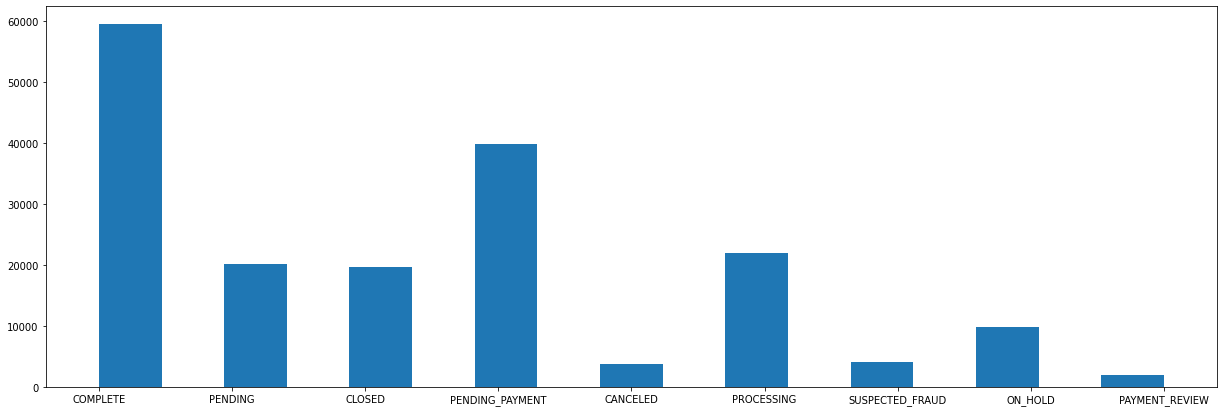

In [ ]:
plt.figure(figsize=(21, 7))
plt.hist(df['Order Status'],bins = int(17))
plt.show()

In [12]:
df['Order Status']=df['Order Status'].replace(['COMPLETE','PENDING','PROCESSING','CANCELED','PENDING_PAYMENT','ON_HOLD','CLOSED','PAYMENT_REVIEW' ],[1,1,1,1,1,1,1,1])
df['Order Status']=df['Order Status'].replace(['SUSPECTED_FRAUD'],[0])

In [13]:
cols = np.percentile(df,[])
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(df.drop(columns=['Order Status']))

MinMaxScaler()

In [16]:
inp_df_scal = pd.DataFrame(scaler.transform(df.drop(columns=['Order Status'])), columns = df.drop(columns=['Order Status']).columns)

In [17]:
outputdf=df['Order Status']

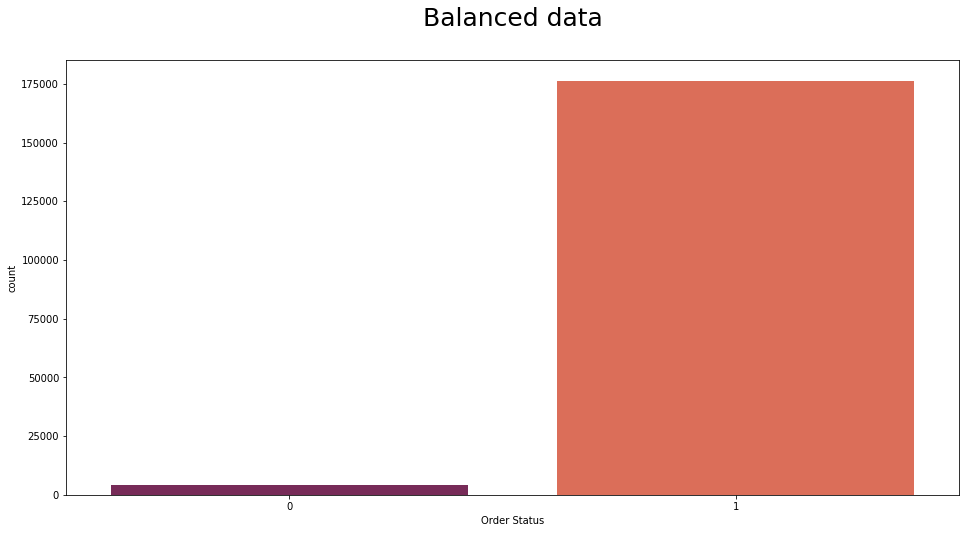

In [ ]:
plt.figure(figsize=(16,8))
sns.countplot(data=df, x="Order Status", palette='rocket')
plt.title("Balanced data\n", fontsize=25)
plt.show()

# Feature Selection

In [18]:
from sklearn.svm import LinearSVC

In [19]:
from sklearn.feature_selection import SelectFromModel

In [20]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(inp_df_scal, outputdf)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [21]:
model = SelectFromModel(lsvc, prefit=True)

In [22]:
mask = model.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, df.drop(columns=['Order Status']).columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat))

The best features are:['Type', 'Days for shipping (real)', 'Benefit per order', 'Delivery Status', 'Late_delivery_risk', 'Customer Segment', 'Customer Zipcode', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Profit Per Order', 'Order State', 'shipping date (DateOrders)', 'Shipping Mode']


In [23]:
svc_sel_x = inp_df_scal[['Type', 'Days for shipping (real)', 'Benefit per order', 
                'Delivery Status', 'Late_delivery_risk', 'Customer Segment', 
                'Customer Zipcode', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Item Id', 
                'Order Profit Per Order', 'Order State', 'shipping date (DateOrders)', 'Shipping Mode']]

# Data Preparation

In [40]:
X_train, X_val, y_train, y_val = train_test_split(svc_sel_x, outputdf, test_size = .2, random_state =1, stratify=outputdf)

Data Transformation

In [25]:
from imblearn.over_sampling import SMOTE #smote

In [26]:
sm = SMOTE(random_state=42)

In [41]:
x_smo, y_smo = sm.fit_resample(X_train,y_train)

In [28]:
#newx = pd.DataFrame(x_smo)
#newx['Order Status'] = y_smo

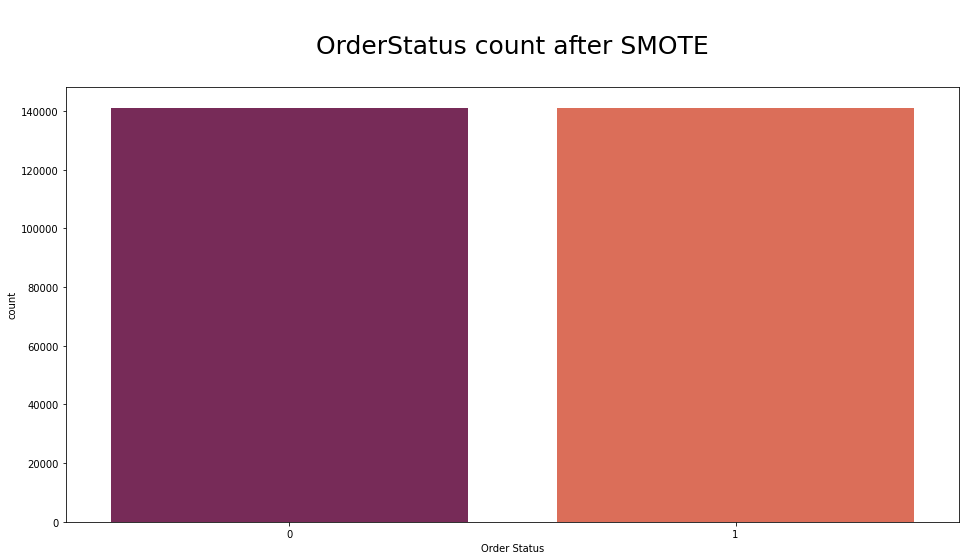

In [29]:
plt.figure(figsize=(16,8))
sns.countplot(data=newx, x="Order Status", palette='rocket')
plt.title("\nOrderStatus count after SMOTE\n", fontsize=25)
plt.show()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x_smo, y_smo, test_size=0.1875, random_state=1)

# Modeling

In [43]:
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 5)
tree.fit(X_train,y_train)
y_dt_pred = tree.predict(X_test)

In [44]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc_pred = rfc.predict(X_test)

In [45]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
ygnb_pred = gnb.predict(X_test)

In [46]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
yxgb_pred = xgb.predict(X_test)

# Classification Reports - Test Set

**Decision Tree - Test Set**

In [47]:
print(classification_report(y_dt_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26870
           1       0.98      1.00      0.99     26066

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



**Random Forest - Test Set**

In [48]:
print(classification_report(y_rfc_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     26545
           1       0.99      1.00      1.00     26391

    accuracy                           1.00     52936
   macro avg       1.00      1.00      1.00     52936
weighted avg       1.00      1.00      1.00     52936



**Gaussian Naive Bayes - Test Set**

In [49]:
print(classification_report(ygnb_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26856
           1       0.98      1.00      0.99     26080

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



**XGBoost - Test Set**

In [50]:
print(classification_report(yxgb_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26872
           1       0.98      1.00      0.99     26064

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



# Classification Reports - Validation Set

**Decision Tree - Validation Set**

In [51]:
dt_val_pred = tree.predict(X_val)

In [52]:
print(classification_report(dt_val_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      1538
           1       0.98      1.00      0.99     34566

    accuracy                           0.98     36104
   macro avg       0.99      0.76      0.84     36104
weighted avg       0.98      0.98      0.98     36104



**Random Forest - Validation Set**

In [53]:
y_rfc_val_pred = rfc.predict(X_val)

In [54]:
print(classification_report(y_rfc_val_pred, y_val))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1090
           1       0.99      1.00      1.00     35014

    accuracy                           0.99     36104
   macro avg       0.99      0.87      0.92     36104
weighted avg       0.99      0.99      0.99     36104



**Gaussian Naive Bayes - Validation Set**

In [55]:
ygnb_val_pred = gnb.predict(X_val)

In [56]:
print(classification_report(ygnb_val_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      1541
           1       0.98      1.00      0.99     34563

    accuracy                           0.98     36104
   macro avg       0.99      0.76      0.84     36104
weighted avg       0.98      0.98      0.98     36104



**XGBoost - Validation Set**

In [57]:
yxgb_val_pred = xgb.predict(X_val)

In [58]:
print(classification_report(yxgb_val_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.52      0.69      1545
           1       0.98      1.00      0.99     34559

    accuracy                           0.98     36104
   macro avg       0.99      0.76      0.84     36104
weighted avg       0.98      0.98      0.98     36104



# Confusion Matrices - Validation Set

**Decision Tree**

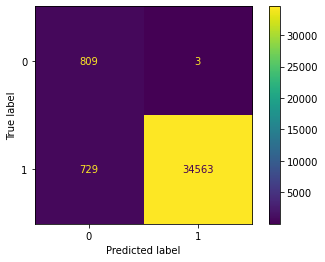

In [59]:
dt_val_cm = confusion_matrix(y_val, dt_val_pred, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_val_cm, display_labels=tree.classes_)
disp.plot()
plt.show()

**Random Forest**

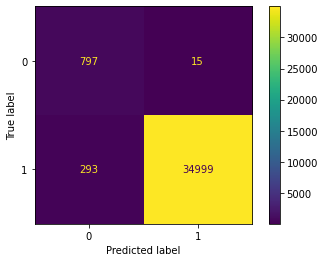

In [60]:
rfc_val_cm = confusion_matrix(y_val,y_rfc_val_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rfc_val_cm, display_labels=rfc.classes_)
disp.plot()
plt.show()

**Gaussian Naive Bayes**

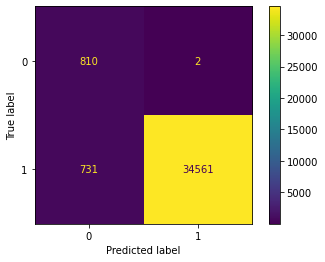

In [61]:
gnb_val_cm = confusion_matrix(y_val,ygnb_val_pred , labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=gnb_val_cm, display_labels=rfc.classes_)
disp.plot()
plt.show()

**XGBoost**

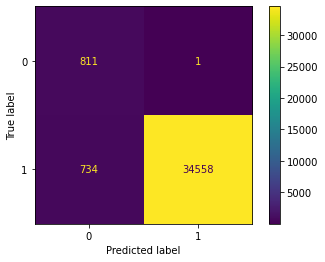

In [62]:
xgb_val_cm = confusion_matrix(y_val,yxgb_val_pred , labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_val_cm, display_labels=xgb.classes_)
disp.plot()
plt.show()